# Red Giant Mode fitting

Fitting $nstars$ RG stars chosen at random using Vrard model.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import random

In [41]:
#import output data
nstars = 50
IDs = []
stardat = pd.read_csv('RGdata/output_1000stars.csv', delim_whitespace=False, header=0, usecols=range(1,4))
for i in range(nstars):
    IDs.append(random.choice(stardat['ID']))

modes = {} # dictionary with frequencies and errors
for i in IDs:
    modes[str(i)] = pd.read_csv('RGdata/modes_'+str(i)+'.csv', delim_whitespace=False, header=0, usecols=[0,7])
    modes[str(i)] = modes[str(i)].sort_values(by=['f0'])
    modes[str(i)] = modes[str(i)].set_index(np.arange(0,len(modes[str(i)]),1))
    modes[str(i)]['dnu'] = modes[str(i)].f0.diff(2).shift(-1)/2
    dnu_avg = np.mean(modes[str(i)].dnu)
    n_min = int(modes[str(i)].f0.min() / dnu_avg)
    n_obs = np.arange(n_min, n_min+len(modes[str(i)].f0), 1)
    modes[str(i)]['n'] = n_obs
    
stardat= stardat.loc[stardat['ID'].isin(IDs)]

To find a ballpark figure before defining priors, will use model:

$$\nu(n)=(n+\epsilon)\langle\Delta\nu\rangle+k(n_{max}-n)^2+\mathcal{A}e^{-n/\tau}sin(nw+\phi)$$

where $n_{max}= \nu_{max}/\Delta\nu - \epsilon$

In [42]:
def echelle(stardat, modes, ID, model=False, stanfit=[], stan_dnu=0):
    numax_obs = float(stardat.loc[stardat['ID'] == ID].Numax)
    numax_obs_err = float(stardat.loc[stardat['ID'] == ID].Numax_err)
    #dnu_obs = float(stardat.loc[stardat.ID == IDs[i]].Dnu_median_all)
    #dnu_obs = np.mean(np.diff(modes[str(IDs[i])].f0)) 
    dnu_obs = np.mean(modes[str(ID)].f0.diff(2).shift(-1)/2)
    # Create dataframes for frequencies and calculate orders n
    l0modes = pd.DataFrame([modes[str(ID)].f0, modes[str(ID)].f0_err])
    l0modes = l0modes.T
    l0modes = l0modes.sort_values('f0', ascending=True)
    n_min = int(l0modes.f0.min() / dnu_obs)
    n_obs = np.arange(n_min, n_min+len(l0modes.f0), 1)
    l0modes['n'] = n_obs
    l0modes = l0modes.set_index(np.arange(0, len(l0modes.f0), 1))
    plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = str(ID))
    
    if model:
        label = 'Stan Fit '+str(ID)
        plt.plot(stanfit % stan_dnu, stanfit, label = label)
        
    plt.xlabel(r'Frequency modulo ($\mu Hz$)')
    plt.ylabel(r'Frequency ($\mu Hz$)')
    plt.legend()

In [43]:
def model(n, dnu, nmax, epsilon, alpha, A, G, phi):
    freqs = (n + epsilon + alpha/2 * (nmax - n)**2 + A*G/(2*np.pi) * np.sin((2*np.pi*(n-nmax))/G + phi))*dnu #* np.exp(-n/tau);
    return freqs

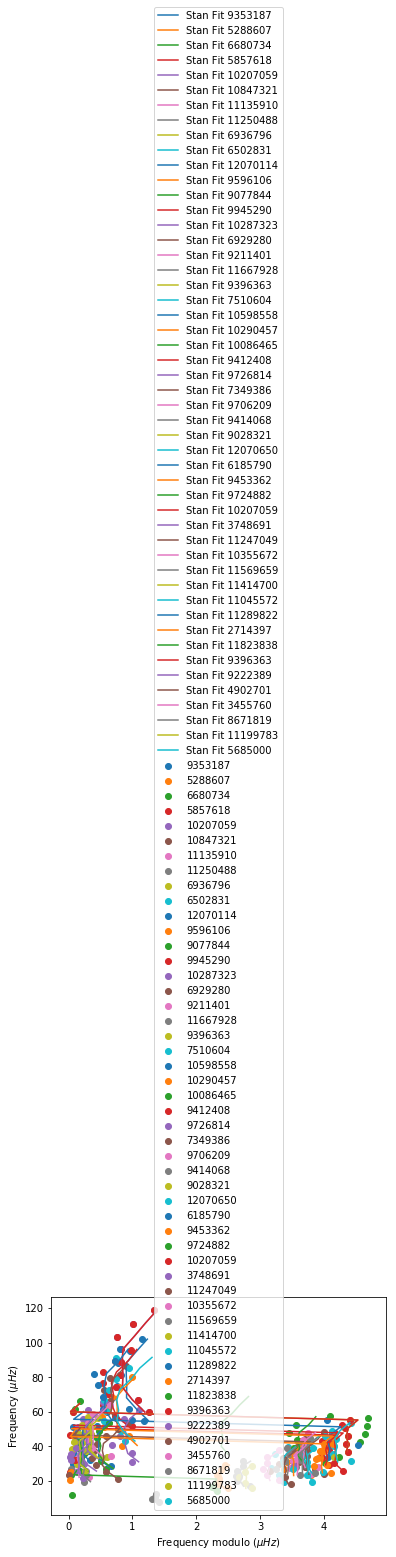

In [44]:
for i in IDs:
    #values from Vrard
    dnu_avg = np.mean(modes[str(i)].dnu)
    n = modes[str(i)].n
    #epsilon = 0.601 + 0.632*np.log(dnu_avg)
    epsilon = np.median((modes[str(i)].f0 % dnu_avg) / dnu_avg)
    numax_obs = float(stardat.loc[stardat['ID'] == i].Numax)
    nmax = numax_obs/dnu_avg - epsilon
    alpha = 0.015*dnu_avg**(-0.32)
    A = 0.06*dnu_avg**(-0.88) 
    G = 3.08
    #tau = 8
    phi = 1.71
    f = model(n, dnu_avg, nmax, epsilon, alpha, A, G, phi)
    echelle(stardat, modes, i, True, f, dnu_avg)
    

In [45]:
'''plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') 
plt.plot(f % dnu_obs, f, label = 'Model')
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
#mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)
plt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')
plt.legend()'''

"plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') \nplt.plot(f % dnu_obs, f, label = 'Model')\nplt.xlabel(r'Frequency modulo ($\\mu Hz$)')\nplt.ylabel(r'Frequency ($\\mu Hz$)')\n#mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)\nplt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')\nplt.legend()"

In [46]:
code = '''
data {
    int N;
    real n[N];
    real freq[N];
    real freq_err[N];
    real dnu_guess;
}
parameters {
    real dnu;
    real nmax;
    real epsilon;
    real alpha;
    real<lower = 0> A;
    real<lower = 0> G;
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi;
    //real<lower = 0> tau;
    real epsA;
    real epsB;
    real alA;
    real alB;
    real AA;
    real AB;
    
}
model {
    real mod[N];
    for (i in 1:N){
        mod[i] = (n[i] + epsilon + (alpha/2) * (nmax - n[i])^2 + 
            A*G/(2*pi()) * sin((2*pi()*(n[i]-nmax))/G + phi))*dnu;
    }
    mod ~ normal(freq, freq_err);
    dnu ~ normal(dnu_guess, dnu_guess*0.001);
    epsilon ~ normal(epsA + epsB*log(dnu), 0.5);
    epsilon ~ uniform(-1.0, 2.0);
    nmax ~ normal(10, 4);
    alpha ~ lognormal(log(alA*dnu^(-alB)), 0.3);
    //alpha ~ lognormal(log(0.015*dnu^(-0.32)), 0.3);
    A ~ lognormal(log(AA*dnu^(-AB)), 0.4);
    //A ~ lognormal(log(0.06*dnu^(-0.88)), 0.4);
    G ~ normal(3.08, 0.65);
    // tau ~ normal(50, 10);
    epsA ~ normal(0.601, 0.080);
    epsB ~ normal(0.632, 0.080);
    alA ~ normal(0.015, 0.005);
    alB ~ normal(0.32, 0.08);
    AA ~ normal(0.06, 0.01);
    AB ~ normal(0.88, 0.05);
}
generated quantities{
    real fm[N];
    for (j in 1:N){
        fm[j] = (n[j] + epsilon + (alpha/2) * (nmax - n[j])^2 + 
            A*G/(2*pi()) * sin((2*pi()*(n[j]-nmax))/G + phi))*dnu;
        }
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0dda3e4b285fc6a0f5224af403aead82 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpdevg1zyt/stanfit4anon_model_0dda3e4b285fc6a0f5224af403aead82_1059014233849018892.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [47]:
fits = {}
for i in IDs:
    dat_star = stardat.loc[stardat['ID'] == i]
    df_star = modes[str(i)]
    df_star = df_star.sort_values(by=['f0'])
    dnu_obs = np.mean(df_star.dnu)
    numax_obs = float(dat_star.loc[dat_star['ID'] == i].Numax)
    df_star = df_star.set_index(np.arange(0, len(df_star.f0), 1))
    nmax_guess = np.mean(df_star.n)
    epsilon_obs = np.median((df_star.f0 % dnu_obs) / dnu_obs)
    #epsilon_obs = 0.601 + 0.632*np.log(dnu_obs)
    alpha_obs = 0.015*dnu_obs**(-0.32)
    A_obs = 0.06*dnu_obs**(-0.88)
    
    data = {'N': len(df_star.f0), 'n': df_star.n.values, 'freq': df_star.f0.values,
            'freq_err': df_star.f0_err.values, 'dnu_guess': dnu_obs}
    start = {'dnu': dnu_obs, 'epsilon': epsilon_obs, 
             'nmax': numax_obs/dnu_obs - epsilon_obs, 'alpha': alpha_obs, 'A': A_obs,
             'G': 3, 'phi': 1.6}
    nchains=4
    fit = sm.sampling(data=data, iter=5000, chains=nchains, init=[start for n in range(nchains)])
    fits[str(i)] = fit
    output = pd.DataFrame({'dnu': fit['dnu'], 'nmax': fit['nmax'], 'epsilon': fit['epsilon'], 
                           'alpha': fit['alpha'], 'A': fit['A'], 'G': fit['G'], 'phi': fit['phi'], 
                           'epsA': fit['epsA'], 'epsB': fit['epsB'], 'alA': fit['alA'], 'alB': fit['alB'],
                           'AA': fit['AA'], 'AB': fit['AB']})
    #output.to_csv('samples_' + str(i) + '.csv')

In [48]:
for i in IDs:
    print('ID = ' + str(i))
    print(fits[str(i)])

ID = 9353187
Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       6.71  9.0e-5 6.7e-3    6.7   6.71   6.71   6.72   6.73   5634    1.0
nmax     11.34  2.2e-3   0.16  11.05  11.23  11.33  11.44  11.67   5007    1.0
epsilon   0.11  1.6e-4   0.01   0.09    0.1   0.11   0.12   0.13   5450    1.0
alpha  10.0e-3  8.7e-6 8.8e-4 8.3e-3 9.4e-310.0e-3   0.01   0.01  10225    1.0
A         0.02  5.4e-5 4.6e-3   0.01   0.02   0.02   0.02   0.03   7343    1.0
G         3.54  3.7e-3   0.29   3.08   3.33   3.51   3.72   4.21   6476    1.0
phi       0.87  5.0e-3   0.36    0.2   0.63   0.87    1.1    1.6   5046    1.0
epsA      0.56  7.3e-4   0.08   0.41   0.51   0.56   0.61   0.71  11096    1.0
epsB      0.56  7.7e-4   0.08    0.4    0.5   0.56   0.61   0.71  10319    1.0
alA    

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       6.57  1.1e-4 6.6e-3   6.55   6.56   6.57   6.57   6.58   3605    1.0
nmax     10.59  1.6e-3   0.09  10.42  10.53  10.59  10.65  10.78   3497    1.0
epsilon   0.09  1.8e-4   0.01   0.07   0.08   0.09    0.1   0.11   3647    1.0
alpha     0.01  1.0e-510.0e-4   0.01   0.01   0.01   0.01   0.02   9074    1.0
A         0.03  5.3e-5 4.4e-3   0.02   0.02   0.03   0.03   0.04   6902    1.0
G         2.55  1.4e-3   0.12   2.33   2.47   2.54   2.62   2.79   7182    1.0
phi       2.51  4.5e-3   0.28   1.97   2.33   2.51    2.7   3.05   3840    1.0
epsA      0.56  7.3e-4   0.08   0.41   0.51   0.56   0.62   0.72  11681    1.0
epsB      0.56  7.1e-4   0.08   0.41   0.51   0.56   0.61   0.71  11828    1.0
alA       0.02  3.5e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       2.67  3.2e-5 2.6e-3   2.66   2.67   2.67   2.67   2.67   6593    1.0
nmax      7.62  2.7e-3    0.2   7.26   7.48   7.61   7.74   8.04   5272    1.0
epsilon   0.87  1.2e-4 9.5e-3   0.85   0.87   0.87   0.88   0.89   6282    1.0
alpha     0.02  3.3e-5 2.9e-3 9.5e-3   0.01   0.01   0.02   0.02   7915    1.0
A         0.03  1.2e-4   0.01   0.01   0.02   0.03   0.04   0.05   7132    1.0
G         2.44  6.8e-3   0.43   1.78   2.17   2.37   2.61   3.56   4062    1.0
phi       0.25    1.86   3.22  -4.91   -3.3   1.89    2.9   4.54      3   2.73
epsA      0.59  7.3e-4   0.08   0.44   0.54   0.59   0.64   0.75  11273    1.0
epsB      0.62  7.4e-4   0.08   0.47   0.57   0.62   0.68   0.78  11455    1.0
alA       0.02  3.8e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.03  5.1e-5 4.0e-3   4.03   4.03   4.03   4.04   4.04   6187    1.0
nmax      7.94  1.5e-3   0.12   7.71   7.86   7.94   8.02   8.19   6143    1.0
epsilon   0.88  1.2e-4 9.6e-3   0.86   0.87   0.88   0.89    0.9   6004    1.0
alpha     0.02  2.5e-5 2.6e-3   0.02   0.02   0.02   0.02   0.03  10825    1.0
A         0.03  9.6e-5 8.9e-3   0.02   0.03   0.03   0.04   0.05   8615    1.0
G         2.99  3.3e-3   0.28   2.53    2.8   2.95   3.15   3.65   7194    1.0
phi       1.08  4.8e-3   0.39   0.32   0.82   1.07   1.33   1.85   6407    1.0
epsA      0.59  6.9e-4   0.08   0.43   0.53   0.59   0.64   0.74  13051    1.0
epsB      0.61  6.9e-4   0.08   0.46   0.56   0.61   0.67   0.76  12915    1.0
alA       0.02  3.3e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.19  6.6e-5 4.2e-3   4.18   4.19   4.19    4.2    4.2   4016    1.0
nmax      7.51  3.5e-3   0.13   7.28   7.42    7.5   7.58   7.77   1311    1.0
epsilon   0.87  1.6e-4 9.0e-3   0.85   0.86   0.87   0.88   0.89   2954    1.0
alpha     0.02  4.8e-5 3.3e-3   0.02   0.02   0.02   0.02   0.03   4772    1.0
A         0.02  1.1e-4 5.9e-3 6.8e-3   0.01   0.02   0.02   0.03   2713   1.01
G         2.95    0.02   0.62   1.65   2.57    2.9   3.31   4.29   1698    1.0
phi      -1.46     0.6   4.18  -6.16  -5.46  -0.69   1.02   6.18     49   1.06
epsA      0.59  1.1e-3   0.08   0.43   0.53   0.59   0.64   0.74   5522    1.0
epsB      0.61  1.0e-3   0.08   0.46   0.56   0.61   0.66   0.76   5941    1.0
alA       0.02  5.2e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.22  5.8e-5 4.1e-3   4.22   4.22   4.22   4.23   4.23   4881    1.0
nmax      8.35  1.5e-3   0.09   8.17   8.29   8.35   8.41   8.54   3923    1.0
epsilon  -0.05  1.2e-4 8.3e-3  -0.07  -0.05  -0.05  -0.04  -0.03   4694    1.0
alpha     0.02  2.2e-5 1.8e-3   0.01   0.02   0.02   0.02   0.02   6329    1.0
A         0.02  7.5e-5 5.8e-3   0.01   0.02   0.02   0.03   0.03   5880    1.0
G         3.03  7.0e-3   0.34   2.56   2.81   2.97   3.18   3.88   2402    1.0
phi       5.97  3.1e-3   0.23   5.43   5.83   6.01   6.15   6.27   5321    1.0
epsA      0.57  7.3e-4   0.08   0.41   0.51   0.56   0.62   0.72  11358    1.0
epsB      0.58  7.4e-4   0.08   0.42   0.52   0.58   0.63   0.73  11177    1.0
alA       0.02  3.6e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       1.61  1.5e-5 1.6e-3   1.61   1.61   1.61   1.61   1.61  11081    1.0
nmax      6.75    0.02   0.93    5.5   6.05   6.54   7.26   9.01   1985    1.0
epsilon   0.82  2.6e-4   0.01   0.79   0.81   0.82   0.83   0.84   2902    1.0
alpha     0.01  1.0e-4 6.1e-3 4.2e-3 8.4e-3   0.01   0.02   0.03   3478    1.0
A         0.06  1.5e-410.0e-3   0.04   0.05   0.06   0.07   0.08   4512    1.0
G         3.21  7.4e-3   0.47    2.4   2.88   3.18   3.51   4.23   3991    1.0
phi       1.65    0.04   1.67  -0.95   0.43   1.38   2.62   5.58   2090    1.0
epsA       0.6  7.9e-4   0.08   0.45   0.55    0.6   0.65   0.75   9650    1.0
epsB      0.63  8.5e-4   0.08   0.47   0.58   0.63   0.69   0.79   8871    1.0
alA       0.01  7.5e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.18  5.9e-5 4.1e-3   4.17   4.18   4.18   4.19   4.19   4805    1.0
nmax      8.39    0.02   0.11   8.19   8.32   8.39   8.46   8.61     50   1.03
epsilon  -0.05  1.4e-4 8.8e-3  -0.07  -0.06  -0.05  -0.05  -0.04   4158    1.0
alpha     0.02  3.0e-5 2.8e-3   0.01   0.02   0.02   0.02   0.03   8671    1.0
A         0.02  7.5e-5 6.5e-3 9.6e-3   0.02   0.02   0.02   0.03   7356    1.0
G         2.53  6.7e-3   0.47   1.76   2.22   2.49   2.76   3.69   4944    1.0
phi       4.08    2.01   3.01  -5.46   2.74   5.59   5.97   6.25      2    3.3
epsA      0.56  7.8e-4   0.08   0.41   0.51   0.56   0.62   0.72  10310    1.0
epsB      0.58  7.7e-4   0.08   0.43   0.53   0.58   0.63   0.73  10588    1.0
alA       0.02  3.6e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       3.87  5.1e-4 3.8e-3   3.86   3.87   3.87   3.87   3.88     57   1.03
nmax      8.71    0.05   0.14   8.45   8.63    8.7   8.79   9.04      7   1.17
epsilon  -0.04  1.3e-3 9.1e-3  -0.06  -0.05  -0.04  -0.04  -0.03     49   1.03
alpha     0.01  1.8e-5 1.9e-3 9.0e-3   0.01   0.01   0.01   0.02  11111    1.0
A         0.04  5.6e-4 8.8e-3   0.03   0.04   0.04   0.05   0.06    250   1.02
G         2.75    0.04   0.25   2.27   2.64   2.77   2.89   3.14     50   1.07
phi       4.59    1.74   2.48  -0.33    3.7   5.95   6.14   6.27      2   7.15
epsA      0.56  7.8e-4   0.08   0.41   0.51   0.56   0.62   0.72   9809    1.0
epsB      0.59  7.5e-4   0.08   0.43   0.53   0.59   0.64   0.74  10525    1.0
alA       0.02  3.7e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       6.01  1.0e-4 6.1e-3   5.99    6.0   6.01   6.01   6.02   3695    1.0
nmax     10.54  7.0e-3   0.21  10.07   10.4  10.55  10.69  10.92    929   1.01
epsilon    0.1  2.5e-4   0.01   0.07   0.09    0.1    0.1   0.12   1961    1.0
alpha   7.6e-3  4.8e-5 1.1e-3 5.6e-3 6.9e-3 7.6e-3 8.3e-3 9.6e-3    481   1.01
A         0.02  9.1e-5 5.3e-3 6.5e-3   0.01   0.01   0.02   0.03   3359    1.0
G         2.73    0.04    0.5   1.89   2.15   2.91   3.08   3.43    137   1.02
phi       0.82    1.41   2.79  -5.64   0.49   1.24   2.46   4.77      4   1.72
epsA      0.56  7.9e-4   0.08   0.41   0.51   0.56   0.62   0.72  10048    1.0
epsB      0.56  7.8e-4   0.08   0.41   0.51   0.56   0.62   0.71   9518    1.0
alA       0.01  4.6e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.61  5.4e-5 4.5e-3    4.6   4.61   4.61   4.61   4.62   6943    1.0
nmax      9.98  1.6e-3   0.13   9.73   9.89   9.98  10.07  10.25   7183    1.0
epsilon  -0.06  1.2e-4   0.01  -0.08  -0.07  -0.06  -0.06  -0.04   6691    1.0
alpha     0.01  3.0e-5 2.6e-3 9.3e-3   0.01   0.01   0.02   0.02   7408    1.0
A         0.02  5.1e-5 5.4e-3   0.01   0.02   0.02   0.03   0.04  10851    1.0
G          3.4  3.7e-3   0.32   2.88   3.18   3.37   3.59   4.13   7228    1.0
phi       0.19    1.93   2.75  -4.94  -1.32   1.61   1.89   2.43      2   8.61
epsA      0.56  7.6e-4   0.08   0.41   0.51   0.56   0.62   0.72  10955    1.0
epsB      0.57  7.8e-4   0.08   0.42   0.52   0.57   0.63   0.72  10305    1.0
alA       0.02  3.7e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       3.99  5.5e-5 4.1e-3   3.98   3.99   3.99   3.99    4.0   5599    1.0
nmax      7.17    0.05   0.49   6.64   6.93   7.08   7.26   8.54    103   1.04
epsilon   0.84  4.0e-4 9.8e-3   0.82   0.83   0.84   0.85   0.86    593   1.01
alpha     0.02  2.2e-4 5.4e-3 7.3e-3   0.01   0.02   0.02   0.03    604    1.0
A         0.06  1.4e-4   0.01   0.04   0.06   0.06   0.07   0.09   5898    1.0
G         3.06    0.01   0.36   2.51   2.79    3.0   3.26   3.93    711   1.01
phi        0.6    0.07   0.79  -0.57   0.18   0.52   0.87   2.45    120   1.04
epsA      0.59  7.6e-4   0.08   0.43   0.53   0.59   0.64   0.74  10245    1.0
epsB      0.61  1.2e-3   0.08   0.45   0.56   0.61   0.67   0.77   4380    1.0
alA       0.02  6.8e

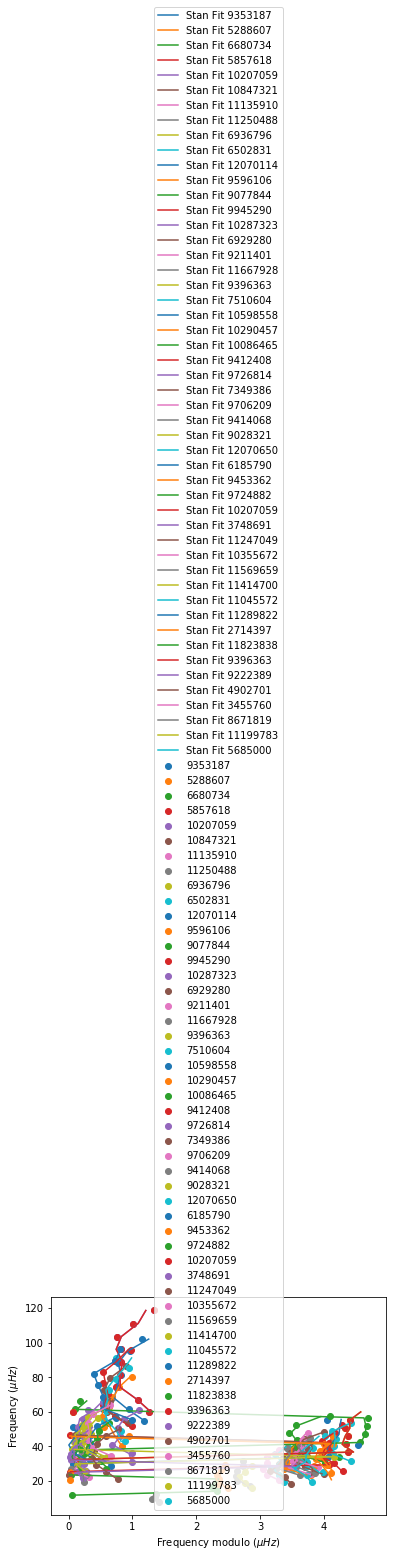

In [49]:
for i in IDs:
    stanfit = model(modes[str(i)].n, fits[str(i)]['dnu'].mean(), fits[str(i)]['nmax'].mean(), fits[str(i)]['epsilon'].mean(), fits[str(i)]['alpha'].mean(), fits[str(i)]['A'].mean(), fits[str(i)]['G'].mean(), fits[str(i)]['phi'].mean())
    stan_dnu = fits[str(i)]['dnu'].mean()
    echelle(stardat, modes, i, True, stanfit, stan_dnu)

In [ ]:
import corner
data = np.vstack([fit['dnu'], fit['nmax'], fit['epsilon'], fit['alpha'], fit['A'], fit['G'], fit['phi'], 
                fit['epsA'], fit['epsB'], fit['alA'], fit['alB'], fit['AA'], fit['AB']]).T
corner.corner(data, labels=['dnu', 'nmax', 'epsilon', 'alpha', 'A', 'G', 'phi', 'epsA', 'epsB', 'alA', 'alB', 'AA', 'AB'])
plt.show()